In [1]:
import numpy as np
import librosa, os, keras, time
import matplotlib.pyplot as plt
import os, csv, numpy as np
from functools import reduce
from pydub.utils import make_chunks

import datetime as dt
import matplotlib.dates as mdates
from matplotlib.collections import PolyCollection

Using TensorFlow backend.


In [18]:
dir_off = './Source_ID/'
dir_pred = './MedleyDB/'
instr = ['pia','gac','gel','vio','voi']
thr = [0.5,0.5,0.5,0.5,0.5]
ours = ['distorted electric guitar', 'clean electric guitar', 'male singer', 'vocalists','female singer', 'piano',
        'acoustic guitar', 'cello', 'clarinet', 'male speaker', 'tack piano', 'lap steel guitar', 'tenor saxophone',
        'violin section', 'trumpet section', 'violin', 'trumpet','cello section', 'clarinet section', 'bass clarinet',
        'electric piano', 'alto saxophone', 'soprano saxophone']

model = keras.models.load_model('ICmodel_96_0.h5')

In [34]:
def merge(l,item):
    if l:
        if l[-1][1] >= item[0]:
            l[-1] = l[-1][0],max(l[-1][1],item[1])
            return l
    l.append(item)
    return l

def model_prediction(predict):
    time = []
    for i in range(len(instr)):
        time.append([])
    prediction = model.predict(predict)
    sec = 0
    for pred in prediction:
        for i in range(len(instr)):
            if (pred[i]>thr[i]): 
                time[i].append([sec,sec+1])
        sec = sec + 1
    return dict(zip(instr,time))

def official(num):
    songs = []
    inst = []
    s = 1
    for file in os.listdir(dir_off):
        if (s != num):
            s = s + 1
            continue
        else: break
            
    song = list(csv.reader(open(dir_off+file,'r')))
    inst = []
    d = dict()
    for i in range(1,len(song)):
        begin = float(song[i][0])
        finish = float(song[i][1])
        instrument = song[i][2]

        #if instrument not in ours: continue
        if instrument in ['cello section','cello']: instrument = 'cel'
        if instrument in ['distorted electric guitar','clean electric guitar','lap steel guitar']: instrument = 'gel'
        if instrument in ['male singer','vocalists','female singer','male speaker']: instrument = 'voi'
        if instrument in ['piano','tack piano','electric piano']: instrument = 'pia'
        if instrument in ['acoustic guitar']: instrument = 'gac'
        if instrument in ['clarinet section','clarinet','bass clarinet']: instrument = 'cla'
        if instrument in ['tenor saxophone','alto saxophone','soprano saxophone']: instrument = 'sax'
        if instrument in ['trumpet section','trumpet']: instrument = 'tru'
        if instrument in ['violin','violin section']: instrument = 'vio'

        if instrument not in inst: inst.append(instrument)
        if instrument in d: d[instrument].append((int(np.floor(begin)),int(np.ceil(finish))))
        else: d[instrument] = [(int(np.floor(begin)),int(np.ceil(finish)))]

    for instrument in inst: d[instrument] = reduce(merge, sorted(d[instrument]), [])
    #if not inst: continue
    for instrument in instr:
        if instrument not in inst: d[instrument] = []
    
    return [file,inst,d]

def prediction(file):
    for f in os.listdir(dir_pred):
        if (f != (file[:-12]+'MIX.wav')): continue
        
        predict = []
        wav,sr = librosa.load(dir_pred+f,mono=True,sr=22050)
        wav = wav / np.sqrt(np.mean(wav**2))
        chunks = []
        #for i in range(2*(len(wav)//sr)-1):
        #    chunks.append(wav[int((i/2)*sr):int((i+2)/2*sr)])
        chunks = make_chunks(wav,sr)
        for ch in chunks[:-1]:
            #mel = librosa.feature.melspectrogram(ch,n_mels=96,fmax=11025,n_fft=1024,hop_length=256,power=1)
            mel = librosa.core.cqt(ch,n_bins=96,bins_per_octave=12,hop_length=256)
            mel = librosa.core.amplitude_to_db(np.abs(mel))
            predict.append(mel)
        predict = np.expand_dims(np.array(predict),-1)
        time = model_prediction(predict)
        
        return time

def bars(inst,time):
    
    y_axis = []
    color = []
    for i in range(len(inst)):
        y_axis.append(i+1)
        color.append('black')

    y,m,d = 2019,8,1
    data = []
    i = 0
    for ins in inst:
        for t in time[ins]:
            data.append( (dt.datetime(y,m,d,t[0]//60,t[0]%60),dt.datetime(y,m,d,t[1]//60,t[1]%60),inst[i]) )
        i = i + 1

    cats = dict(zip(inst,y_axis))
    colormapping = dict(zip(inst,color))
    
    verts = []
    colors = []
    for d in data:
        v =  [(mdates.date2num(d[0]), cats[d[2]]-.4),
              (mdates.date2num(d[0]), cats[d[2]]+.4),
              (mdates.date2num(d[1]), cats[d[2]]+.4),
              (mdates.date2num(d[1]), cats[d[2]]-.4)]
        verts.append(v)
        colors.append(colormapping[d[2]])

    bars = PolyCollection(verts,facecolors=colors)
    fig, ax = plt.subplots()
    ax.add_collection(bars)
    ax.autoscale()
    loc = mdates.MinuteLocator(byminute=[0,1,3,4])
    #ax.xaxis.set_major_locator(loc)
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(loc))

    ax.set_yticks(y_axis)
    ax.set_yticklabels(inst)
    plt.show()

Intervals for drum set : [(5, 189)]
Intervals for fx/processed sound : [(50, 55), (57, 62), (64, 69), (71, 75), (77, 87), (172, 192)]
Intervals for electric bass : [(7, 78), (82, 195)]
Intervals for gel : [(2, 78), (82, 190)]
Intervals for pia : [(105, 161)]
Intervals for cel : [(95, 116), (118, 162), (185, 192)]
Intervals for trombone : [(92, 161)]
Intervals for cla : [(82, 162)]

Official bar interpretation for AimeeNorwich_Flying_SOURCEID.lab :


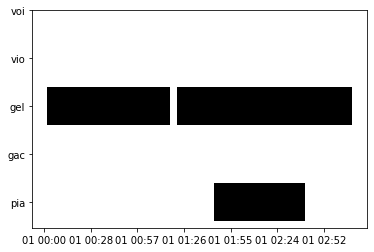

Predicted bar interpretation for AimeeNorwich_Flying_SOURCEID.lab :


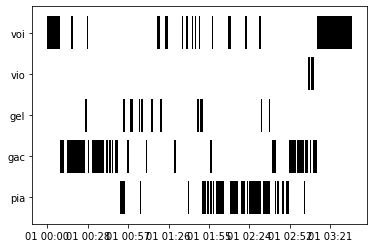

Intervals for gac : [(0, 297), (307, 409)]
Intervals for gel : [(58, 295), (318, 409)]
Intervals for electric bass : [(0, 297), (307, 406)]
Intervals for drum set : [(0, 290), (297, 406)]
Intervals for voi : [(11, 22), (23, 34), (35, 58), (60, 63), (64, 93), (110, 139), (140, 145), (146, 151), (152, 157), (159, 164), (165, 194), (257, 283)]
Intervals for brass section : [(58, 99), (158, 200), (246, 288), (329, 407)]
Intervals for viola section : [(58, 99), (158, 199), (247, 288), (318, 406)]
Intervals for harmonica : [(0, 12), (98, 113), (222, 284)]

Official bar interpretation for AlexanderRoss_GoodbyeBolero_SOURCEID.lab :


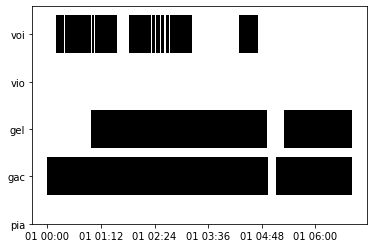

Predicted bar interpretation for AlexanderRoss_GoodbyeBolero_SOURCEID.lab :


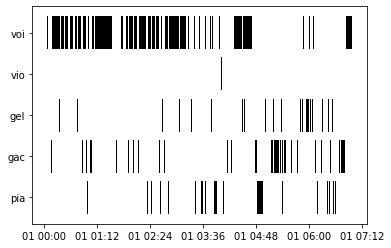

Intervals for gac : [(0, 331), (333, 508)]
Intervals for gel : [(98, 164), (268, 330), (379, 501)]
Intervals for electric bass : [(98, 333), (348, 491)]
Intervals for drum set : [(96, 180), (181, 183), (184, 192), (193, 215), (216, 330), (348, 492)]
Intervals for voi : [(12, 58), (59, 98), (111, 121), (122, 131), (134, 144), (146, 154), (170, 181), (182, 211), (212, 227), (228, 269), (281, 291), (292, 301), (304, 312), (316, 324), (349, 361), (364, 374), (379, 391), (393, 491)]
Intervals for brass section : [(268, 332), (400, 491)]
Intervals for string section : [(268, 332), (429, 491)]

Official bar interpretation for AlexanderRoss_VelvetCurtain_SOURCEID.lab :


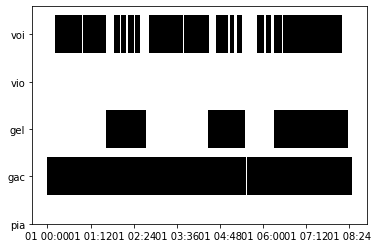

Predicted bar interpretation for AlexanderRoss_VelvetCurtain_SOURCEID.lab :


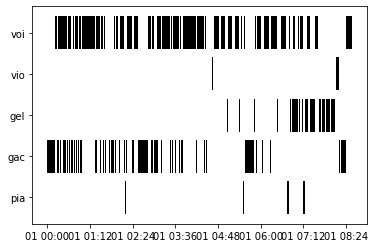

Intervals for gel : [(2, 175)]
Intervals for fx/processed sound : [(76, 79), (80, 138)]

Official bar interpretation for AmarLal_Rest_SOURCEID.lab :


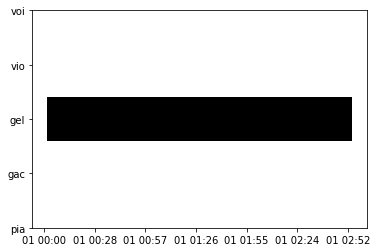

Predicted bar interpretation for AmarLal_Rest_SOURCEID.lab :


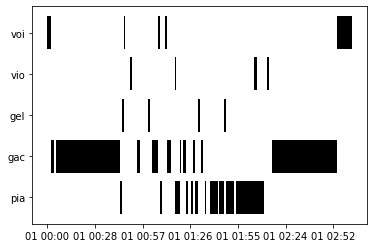

Intervals for gac : [(1, 130)]

Official bar interpretation for AmarLal_SpringDay1_SOURCEID.lab :


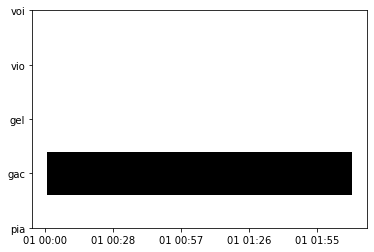

Predicted bar interpretation for AmarLal_SpringDay1_SOURCEID.lab :


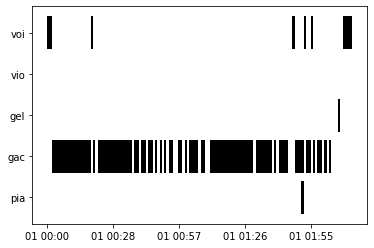

Intervals for banjo : [(67, 82), (84, 91), (94, 203)]
Intervals for electric bass : [(30, 205)]
Intervals for voi : [(0, 23), (27, 43), (46, 47), (52, 71), (90, 91), (96, 165)]
Intervals for drum set : [(30, 204)]
Intervals for gel : [(0, 67), (119, 203)]
Intervals for horn section : [(18, 56), (67, 205)]
Intervals for vibraphone : [(24, 34), (53, 205)]
Intervals for auxiliary percussion : [(0, 205)]
Intervals for pia : [(67, 203)]

Official bar interpretation for Auctioneer_OurFutureFaces_SOURCEID.lab :


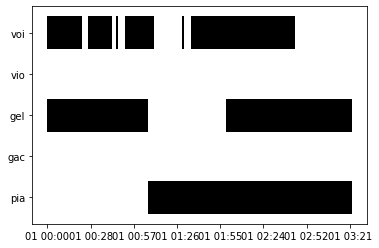

Predicted bar interpretation for Auctioneer_OurFutureFaces_SOURCEID.lab :


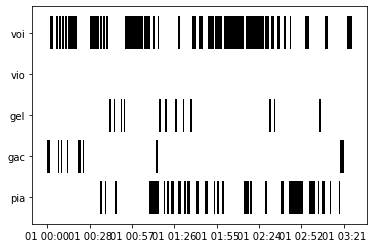

Intervals for electric bass : [(0, 62), (63, 89), (90, 102), (103, 108), (109, 120), (121, 127), (140, 155), (156, 199), (200, 211), (212, 217), (218, 229)]
Intervals for synthesizer : [(0, 50), (51, 53), (54, 56), (57, 59), (63, 76), (84, 89), (91, 95), (96, 102), (103, 108), (109, 120), (140, 152), (156, 170), (171, 199), (200, 211), (212, 217), (218, 230), (231, 236), (237, 242)]
Intervals for voi : [(49, 53), (55, 62), (65, 68), (71, 86), (87, 89), (93, 102), (105, 110), (111, 123), (128, 141), (142, 146), (147, 154), (155, 161), (163, 199), (202, 219), (221, 229), (233, 236), (239, 243)]
Intervals for drum set : [(0, 120), (121, 129), (140, 245)]
Intervals for gel : [(0, 55), (74, 90), (91, 102), (103, 108), (109, 120), (121, 127), (128, 199), (200, 211), (212, 217), (218, 230), (231, 236), (237, 255)]
Intervals for fx/processed sound : [(75, 86), (145, 147), (151, 157), (161, 164), (168, 195)]
Intervals for vibraphone : [(74, 90), (92, 96), (104, 122), (170, 231), (232, 237), (23

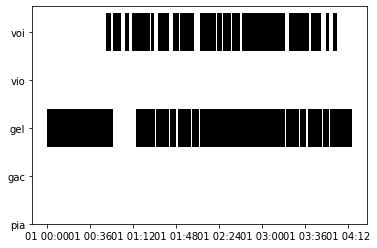

Predicted bar interpretation for AvaLuna_Waterduct_SOURCEID.lab :


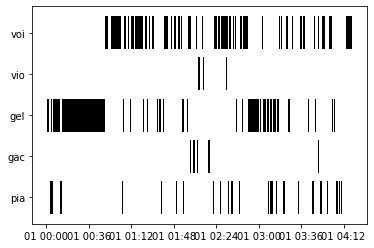

Intervals for electric bass : [(1, 147)]
Intervals for drum set : [(0, 145)]
Intervals for gel : [(0, 146)]
Intervals for voi : [(9, 60), (61, 91), (123, 142)]

Official bar interpretation for BigTroubles_Phantom_SOURCEID.lab :


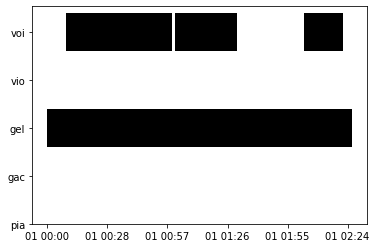

Predicted bar interpretation for BigTroubles_Phantom_SOURCEID.lab :


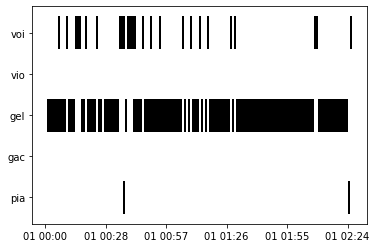

Intervals for voi : [(0, 170)]
Intervals for pia : [(1, 167), (168, 170)]

Official bar interpretation for BrandonWebster_DontHearAThing_SOURCEID.lab :


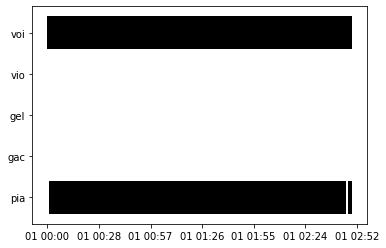

Predicted bar interpretation for BrandonWebster_DontHearAThing_SOURCEID.lab :


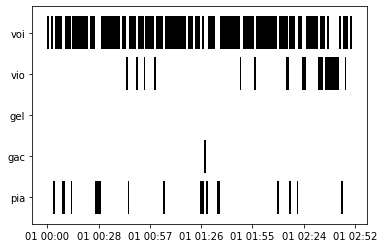

Intervals for pia : [(0, 93)]
Intervals for voi : [(3, 100)]

Official bar interpretation for BrandonWebster_YesSirICanFly_SOURCEID.lab :


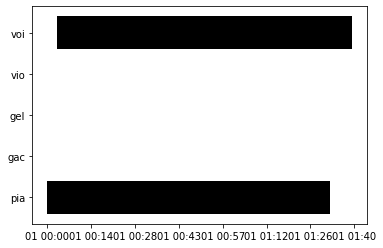

Predicted bar interpretation for BrandonWebster_YesSirICanFly_SOURCEID.lab :


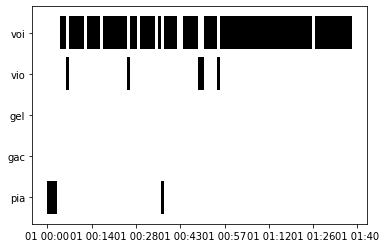

Intervals for voi : [(9, 18), (19, 28), (29, 37), (38, 47), (49, 55), (57, 75), (95, 104), (105, 114), (115, 122), (124, 145)]
Intervals for electric bass : [(9, 117), (119, 126), (127, 273)]
Intervals for synthesizer : [(11, 52), (76, 118)]
Intervals for gel : [(0, 279)]
Intervals for drum set : [(9, 118), (119, 126), (127, 272)]
Intervals for pia : [(76, 95)]

Official bar interpretation for CelestialShore_DieForUs_SOURCEID.lab :


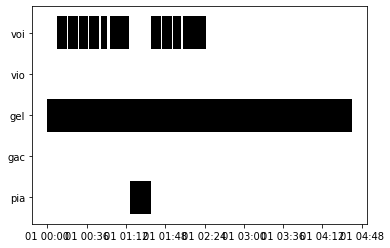

Predicted bar interpretation for CelestialShore_DieForUs_SOURCEID.lab :


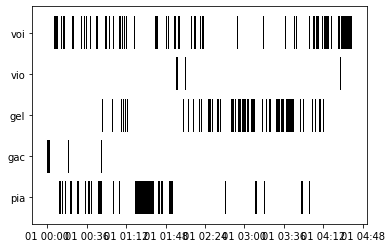

Intervals for drum machine : [(2, 246)]
Intervals for mandolin : [(0, 249)]
Intervals for gel : [(2, 247)]
Intervals for tabla : [(13, 246)]

Official bar interpretation for ChrisJacoby_BoothShotLincoln_SOURCEID.lab :


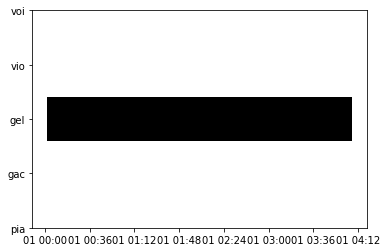

Predicted bar interpretation for ChrisJacoby_BoothShotLincoln_SOURCEID.lab :


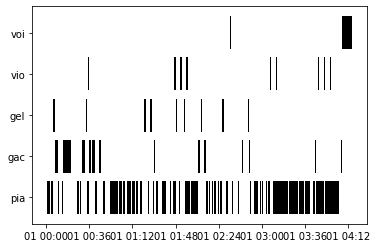

Intervals for kick drum : [(0, 169), (208, 331)]
Intervals for mandolin : [(0, 351)]
Intervals for electric bass : [(21, 362)]
Intervals for tabla : [(22, 361)]

Official bar interpretation for ChrisJacoby_PigsFoot_SOURCEID.lab :


ValueError: Cannot convert -1 to a date.  This often happens if non-datetime values are passed to an axis that expects datetime objects.

<Figure size 432x288 with 1 Axes>

Predicted bar interpretation for ChrisJacoby_PigsFoot_SOURCEID.lab :


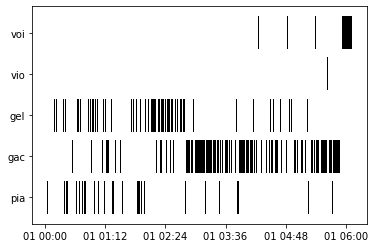

Intervals for drum set : [(51, 151)]
Intervals for timpani : [(51, 55), (67, 71), (82, 87), (98, 103), (135, 139)]
Intervals for electric bass : [(51, 154)]
Intervals for gel : [(6, 25), (51, 155)]
Intervals for pia : [(0, 157)]
Intervals for voi : [(16, 97), (100, 165)]

Official bar interpretation for ClaraBerryAndWooldog_AirTraffic_SOURCEID.lab :


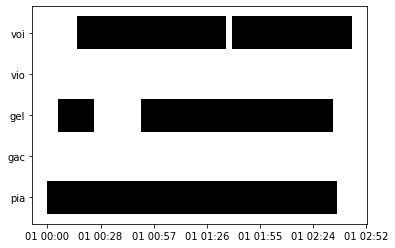

Predicted bar interpretation for ClaraBerryAndWooldog_AirTraffic_SOURCEID.lab :


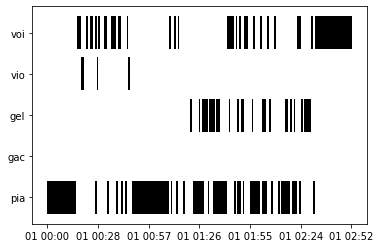

Intervals for drum set : [(12, 132)]
Intervals for snare drum : [(31, 121)]
Intervals for brass section : [(31, 71), (81, 121)]
Intervals for timpani : [(31, 72), (81, 121)]
Intervals for pia : [(0, 144)]
Intervals for voi : [(4, 35), (39, 86), (97, 142)]
Intervals for sax : [(81, 125)]

Official bar interpretation for ClaraBerryAndWooldog_Boys_SOURCEID.lab :


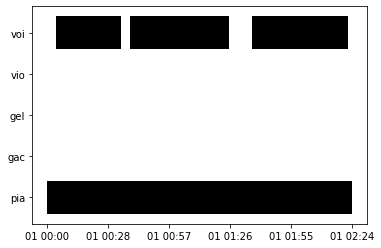

Predicted bar interpretation for ClaraBerryAndWooldog_Boys_SOURCEID.lab :


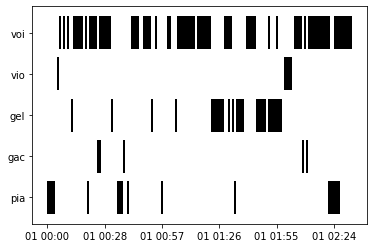

Intervals for drum set : [(46, 73), (75, 141), (142, 185)]
Intervals for auxiliary percussion : [(48, 72), (76, 139), (142, 150), (159, 184)]
Intervals for vibraphone : [(61, 86), (138, 148), (150, 158)]
Intervals for electric bass : [(8, 75), (76, 196)]
Intervals for pia : [(0, 187)]
Intervals for synthesizer : [(76, 140), (142, 150), (159, 189)]
Intervals for voi : [(17, 31), (34, 44), (47, 82), (84, 98), (101, 110), (114, 148), (150, 158), (159, 185)]

Official bar interpretation for ClaraBerryAndWooldog_Stella_SOURCEID.lab :


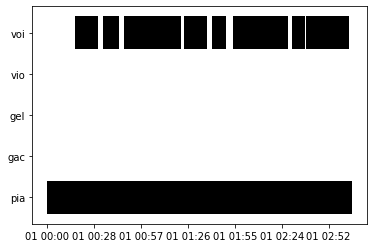

Predicted bar interpretation for ClaraBerryAndWooldog_Stella_SOURCEID.lab :


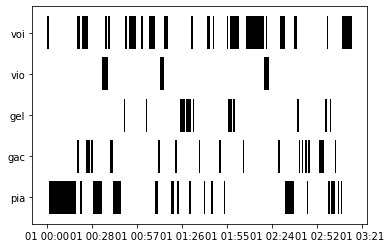

Intervals for pia : [(0, 242)]
Intervals for voi : [(30, 96), (97, 109), (110, 161), (164, 174), (176, 189), (191, 203), (206, 219), (220, 235)]

Official bar interpretation for ClaraBerryAndWooldog_TheBadGuys_SOURCEID.lab :


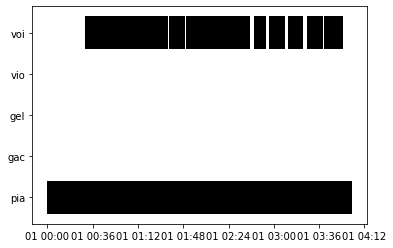

Predicted bar interpretation for ClaraBerryAndWooldog_TheBadGuys_SOURCEID.lab :


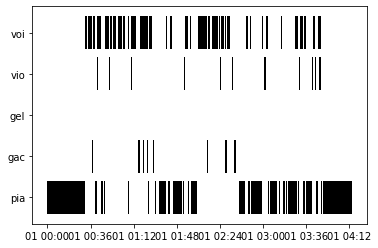

In [44]:
for i in range(3,20):  
    [file,inst,d] = official(i) # 2nd song does not play
    for i in range(len(inst)):
        print('Intervals for',inst[i],':',d[inst[i]])
    print()
    print("Official bar interpretation for",file,":")
    bars(instr,d)


    time = prediction(file)
    print("Predicted bar interpretation for",file,":")
    bars(instr,time)


### Mixing Samples - Accuracy

In [ ]:
# libraries and data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
# Make a data frame
df=pd.DataFrame({'x': [0,2.5,5,7.5,10], 'LRAP': [0.859,0.813,0.837,0.85,0.878],
                                      'Exist': [0.8117,0.805,0.821,0.835,0.85],
                                      'AUC': [0.8958,0.8906,0.89,0.8926,0.89], 
                                      'Diff': [0.7816,0.738,0.74,0.7504,0.75] })
# style
plt.style.use('seaborn-darkgrid')
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in df.drop('x', axis=1):
    num+=1
    plt.plot(df['x'], df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)
 
# Add legend
plt.legend()

# Add titles
plt.title("Mix accuracy", loc='center', fontsize=12, fontweight=0, color='blue')
plt.xlabel("Mix Data")
plt.ylabel("Score")
